In [1]:
%pwd

'c:\\Users\\Fahmi Maulana\\Documents\\Projects\\antam-forecasting\\exploratory-data-analysis\\notebooks'

In [2]:
%cd ../..

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tseries.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from tseries.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

from datetime import datetime
import locale


# plt.rcParams['figure.figsize']=(30,20)
# plt.rcParams['axes.labelsize']=20
plt.rcParams['axes.grid'] = False

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting\tseries\utils\data_utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Helper Functions

Unit Root Test Function

In [4]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

Stationary Technique Functions

In [5]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(12).mean().plot(ax=ax[v,r], legend=False)

Find Missing Dates Function

In [6]:
def missing_dates(timeseriesdata):
    """
    Find and print missing dates in a time series data after filling missing values.

    """
    # Generate a reference date range covering the entire period of your data
    start_date = timeseriesdata.index.min()
    end_date = timeseriesdata.index.max()
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Check for missing dates by comparing the reference date range with the actual dates in your data
    missing_dates = full_date_range[~full_date_range.isin(timeseriesdata.index)]

    # Print the missing dates, if any
    if len(missing_dates) == 0:
        print("No missing dates found.")
    else:
        print("Missing dates:")
        print(missing_dates)


Multiple Data Checker

In [7]:
def multiple_data(data, group_by_column='Date', count_column='Gold Price'):
    """
    Check for dates with multiple values in the specified count_column in the provided data.

    Parameters:
    - data: DataFrame, the data to be checked.
    - group_by_column: str, the column to group the data by specific column.
    - count_column: str, the column for which unique values are counted specific column.

    Returns:
    - None
    """
    # Group the data by the specified group_by_column and count the number of unique values in count_column for each group
    multiple_values = data.groupby(group_by_column)[count_column].nunique()

    # Filter groups where there are multiple values
    groups_with_multiple_values = multiple_values[multiple_values > 1]

    # Print the groups with multiple values
    if groups_with_multiple_values.empty:
        print(f"No {count_column}s with multiple values found.")
    else:
        print(f"{group_by_column}s with multiple {count_column}s:")
        print(groups_with_multiple_values)


# Loading Data
## Load all the data used in the analysis

In [8]:
data = pd.read_csv('./data/harga-emas-antam.csv', parse_dates=["Timestamp", "Date"])
data2 = data[data["Date"] <= "2024-04-30"].copy()


In [9]:
data2.tail()

,Timestamp,Date,Gold Price
4286,2024-04-26 07:57:24,2024-04-26,1319000
4287,2024-04-27 08:30:25,2024-04-27,1326000
4288,2024-04-28 08:07:13,2024-04-28,1326000
4289,2024-04-29 07:56:23,2024-04-29,1325000
4290,2024-04-30 08:19:45,2024-04-30,1325000


In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4291 entries, 0 to 4290
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   4291 non-null   datetime64[ns]
 1   Date        4291 non-null   datetime64[ns]
 2   Gold Price  4291 non-null   int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 134.1 KB


## Checking Duplicate Data

In [11]:
# Checking multiple data
multiple_data(data2,group_by_column='Date',count_column='Gold Price')

Dates with multiple Gold Prices:
Date
2010-05-07    2
2010-05-10    2
2010-06-03    2
2010-10-07    2
2010-12-01    2
2011-03-16    2
2011-08-05    2
2011-08-08    2
2011-08-09    3
2011-08-15    2
2011-08-18    2
2011-08-19    2
2011-09-13    2
2011-09-14    2
2011-11-11    2
2011-12-16    2
2012-02-03    2
2012-05-04    2
2012-05-10    2
2012-10-22    2
2012-11-07    2
2012-11-13    2
2013-08-28    2
2013-10-30    2
2014-01-02    2
2014-02-04    2
2015-02-11    2
2015-03-02    2
2015-03-26    2
2015-04-17    2
2015-05-13    2
2016-06-16    2
2016-06-24    2
2016-11-09    2
2017-10-03    2
2018-08-07    2
2018-11-15    2
2019-06-21    2
2020-02-24    2
2020-03-20    2
2020-03-23    2
2020-07-28    2
2020-09-01    2
2022-02-24    3
Name: Gold Price, dtype: int64


In [12]:
#Select only one value of these multiple data
# Find the row with the latest timestamp for each date
latest_indices = data2.groupby('Date')['Timestamp'].idxmax()

# Select the rows corresponding to the latest timestamps and keep 'Date' and 'Gold Price' columns
data2 = data2.loc[latest_indices, ['Date', 'Gold Price']]

# Drop duplicate rows
data2 = data2.drop_duplicates(keep='first')

# Reset the index to make 'Date' a regular column again
data2.reset_index(drop=True, inplace=True)

# Checking multiple data
multiple_data(data2,group_by_column='Date',count_column='Gold Price')


No Gold Prices with multiple values found.


## Check Missing Dates

In [13]:
#check missing dates
missing_dates(data2.set_index('Date'))

Missing dates:
DatetimeIndex(['2010-01-09', '2010-01-10', '2010-01-16', '2010-01-17',
               '2010-01-23', '2010-01-24', '2010-01-30', '2010-01-31',
               '2010-02-06', '2010-02-07',
               ...
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-07-01', '2023-12-30', '2023-12-31', '2024-01-01',
               '2024-04-10', '2024-04-11'],
              dtype='datetime64[ns]', length=1044, freq=None)


In [14]:
# Set index for Date column
data2.set_index("Date", inplace=True)
# Reindex the DataFrame to include all dates in the desired range
daily_full_index = pd.date_range(start=data2.index.min(), end=data2.index.max(), freq='D')
daily_full_index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13',
               ...
               '2024-04-21', '2024-04-22', '2024-04-23', '2024-04-24',
               '2024-04-25', '2024-04-26', '2024-04-27', '2024-04-28',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', length=5231, freq='D')

In [15]:
data2_reindexed = data2.reindex(daily_full_index)
data2_reindexed

,Gold Price
2010-01-04,408000.0
2010-01-05,410000.0
2010-01-06,410000.0
2010-01-07,412000.0
2010-01-08,410000.0
...,...
2024-04-26,1319000.0
2024-04-27,1326000.0
2024-04-28,1326000.0
2024-04-29,1325000.0


In [16]:
# Fill missing values with the previous date's gold price value
data2_cleaned = data2_reindexed.fillna(method='ffill')
# Reset the index and restore the 'Date' column
data2_cleaned.reset_index(inplace=True)
data2_cleaned.rename(columns={'index': 'Date'}, inplace=True)

# Print the DataFrame with missing dates filled
print("Gold prices with missing dates filled:")
data2_cleaned

Gold prices with missing dates filled:


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\2850452768.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data2_cleaned = data2_reindexed.fillna(method='ffill')


,Date,Gold Price
0,2010-01-04,408000.0
1,2010-01-05,410000.0
2,2010-01-06,410000.0
3,2010-01-07,412000.0
4,2010-01-08,410000.0
...,...,...
5226,2024-04-26,1319000.0
5227,2024-04-27,1326000.0
5228,2024-04-28,1326000.0
5229,2024-04-29,1325000.0


In [17]:
data2.isnull().sum()

Gold Price    0
dtype: int64

# Preview Data

In [18]:
data2_cleaned.info()
data2_cleaned.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 0 to 5230
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5231 non-null   datetime64[ns]
 1   Gold Price  5231 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 81.9 KB


,count,mean,min,25%,50%,75%,max,std
Date,5231,2017-03-02 23:59:59.999999744,2010-01-04 00:00:00,2013-08-03 12:00:00,2017-03-03 00:00:00,2020-09-30 12:00:00,2024-04-30 00:00:00,NaN
Gold Price,5231.0,705158.459186,394000.0,564000.0,617000.0,930000.0,1347000.0,207328.180877


## Visualize Data Trendline 

In [19]:
fig = px.line(data2_cleaned, x='Date', y='Gold Price', title='Gold Price Time Series')
fig.update_xaxes(rangeslider_visible=True)

# Format y-axis ticks as currency
locale.setlocale(locale.LC_NUMERIC, 'id_ID')
fig.update_yaxes(tickprefix='Rp')

# Set the height and width of the chart
fig.update_layout(height=600, width=1000)

# Center-align the title
fig.update_layout(title_x=0.5)

fig.show()

# Checking Time Series Parameters

## Decompose Time Series

### Classic

<Figure size 1500x3000 with 0 Axes>

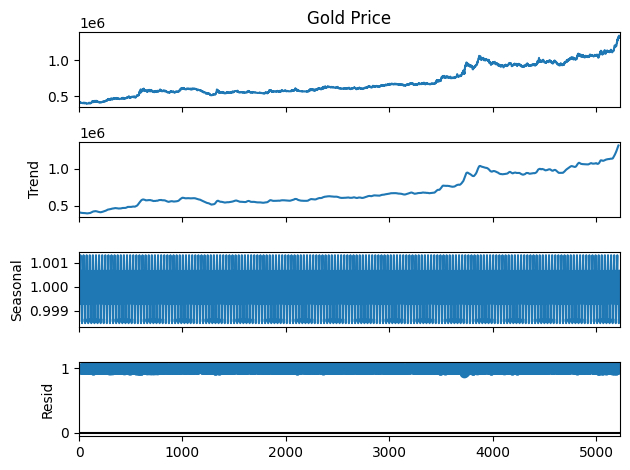

In [20]:
#Decompose
plt.figure(figsize=(15,30))
decomposition = seasonal_decompose(data2_cleaned['Gold Price'], model='multiplicative', period=30)
decomposition.plot()
plt.show()

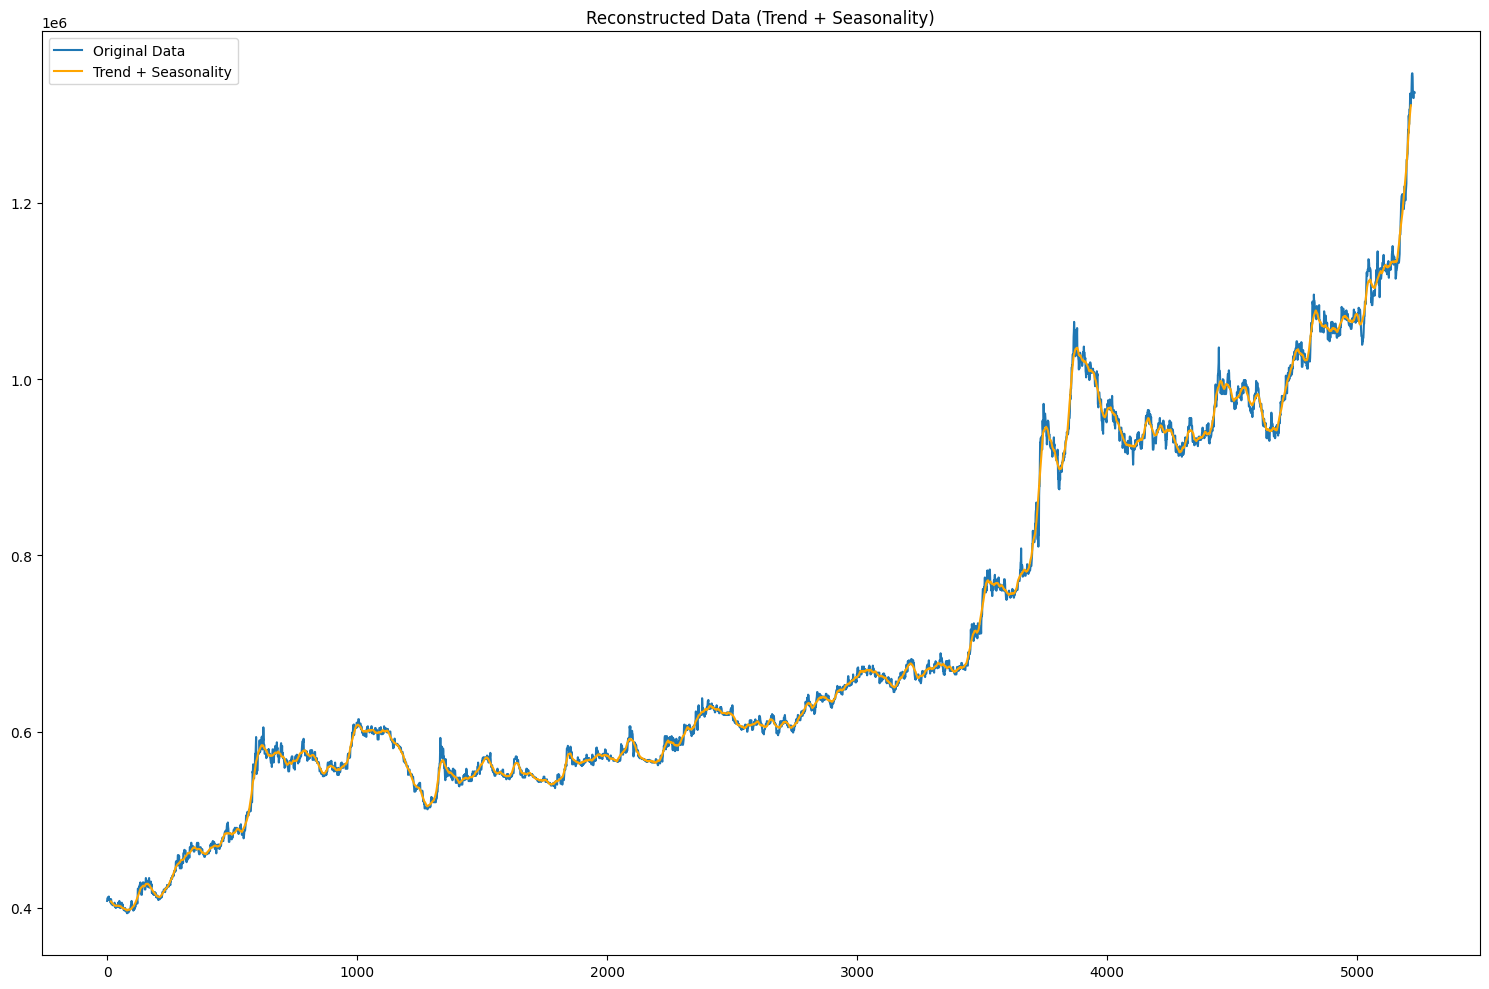

In [21]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

reconstructed = trend * seasonal

# Plot perbandingan antara data asli dengan hasil dekomposisi
plt.figure(figsize=(15, 10))

plt.plot(data2_cleaned['Gold Price'], label='Original Data')
plt.plot(reconstructed, label='Trend + Seasonality', color='orange')
plt.title('Original Data')
plt.title('Reconstructed Data (Trend + Seasonality)')
plt.legend()

plt.tight_layout()
plt.show()

## Stationarity Check

### Detecting Unit Root: ADF & KPSS Test

In [22]:
adf_price_output = adfuller(data2_cleaned.set_index("Date"))
kpss_price_output = kpss(data2_cleaned.set_index("Date"))

pd.concat([
    unitroot_test_results(adf_price_output, 'adf'),
    unitroot_test_results(kpss_price_output, 'kpss')
], axis=1)

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\3140296428.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,adf,kpss
Test Statistic,1.762581,10.49385
p-value,0.998272,0.01
Numbers of lags,2,43
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.431601,0.739
Critical Value (5%),-2.862093,0.463
Critical Value (10%),-2.567064,0.347
Critical Value (2.5%),NaN,0.574


### Detecting Trend

In [23]:
kendall_tau_res = check_trend(data2_cleaned.set_index("Date"), confidence=0.05)
mann_kendall_res = check_trend(data2_cleaned.set_index("Date"), confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(data2_cleaned.set_index("Date"), confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: True | Direction: increasing | Deterministic: False


### Detrending & Deseasonalizing Techniques

#### AutoStationary

In [24]:
data2_cleaned = data2_cleaned.set_index("Date")

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting\tseries\transforms\target_transformations.py:545: UserWarning:

Trends with degree>1 are very strong and use with care.



Transformations applied: ['DetrendingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


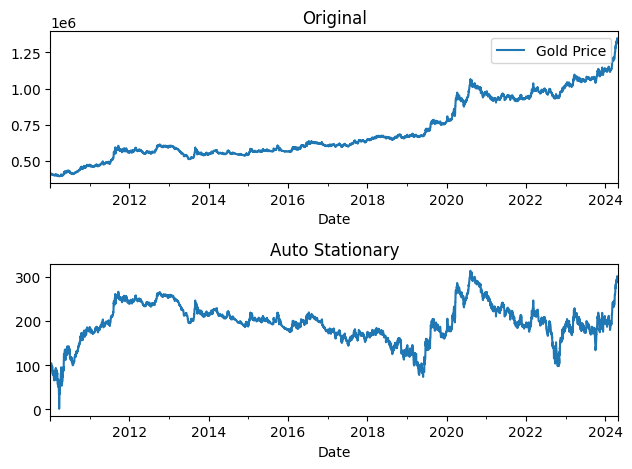

Unit Root: True with a p-value of 0.05493183394063438
Inverse == Original @ precision of 2 decimal points: True


In [25]:
# Set the frequency of the time series data to 'D'
data2_cleaned.index.freq = 'D'

# Now proceed with the rest of your code
auto_stationary = AutoStationaryTransformer(confidence=0.1,
                                            seasonal_period=72,
                                            seasonality_max_lags=180,
                                            detrender_params={'degree':2}, 
                                            deseasonalizer_params = {
                                                "seasonality_extraction": "period_averages",
                                            },
                                            trend_check_params={"mann_kendall":True},
                                            box_cox_params={ "optimization": "guerrero" })
y_stat = auto_stationary.fit_transform(data2_cleaned,freq='D')
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

data2_cleaned.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.1)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), index=data2_cleaned.index, columns=["Gold Price"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==data2_cleaned.round(3))}")

#### Other Techniques

Optimal Lambda: -0.6850073380888527


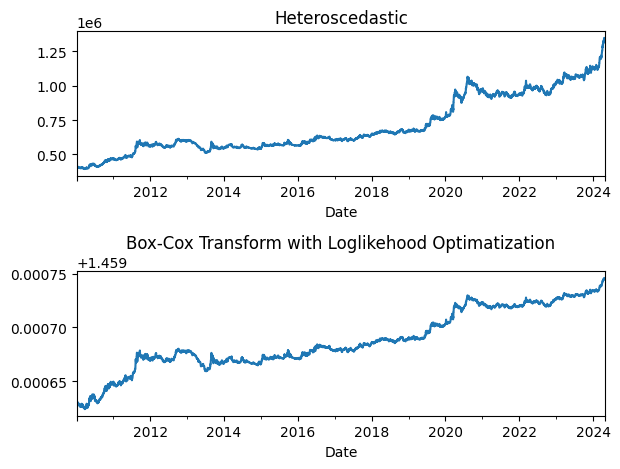

White Test for Heteroscedasticity: True with a p-value of 1.39773693256557e-190


In [26]:
#shifting the series into positive domain
boxcox_transformer = BoxCoxTransformer(add_one=True, optimization="loglikelihood", seasonal_period=90)
y_boxcox_loglikelihood = boxcox_transformer.fit_transform(data2_cleaned["Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")

fig, axs = plt.subplots(2)
data2_cleaned["Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_loglikelihood.plot(title="Box-Cox Transform with Loglikehood Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()

hetero_res = check_heteroscedastisticity(y_boxcox_loglikelihood, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

Optimal Lambda: -0.5153480856867957


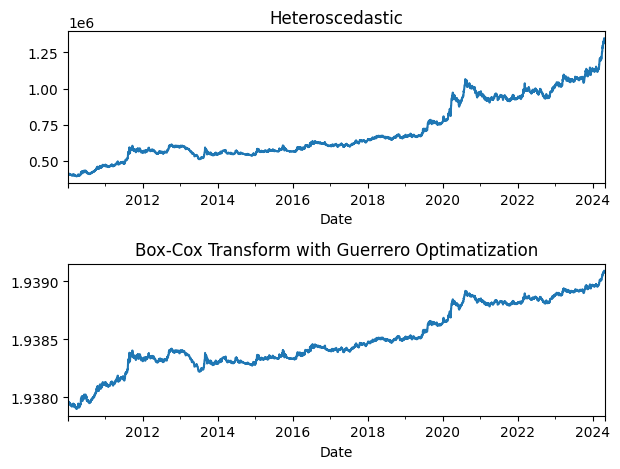

White Test for Heteroscedasticity: True with a p-value of 1.200689075307459e-123


In [27]:
#Arbritarily divided the data into sub-series of length 12
boxcox_transformer = BoxCoxTransformer(seasonal_period=90, add_one=True, optimization="guerrero")
y_boxcox_guerrero = boxcox_transformer.fit_transform(data2_cleaned["Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
data2_cleaned["Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_guerrero.plot(title="Box-Cox Transform with Guerrero Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox_guerrero, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33328\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Fahmi Maulana\A

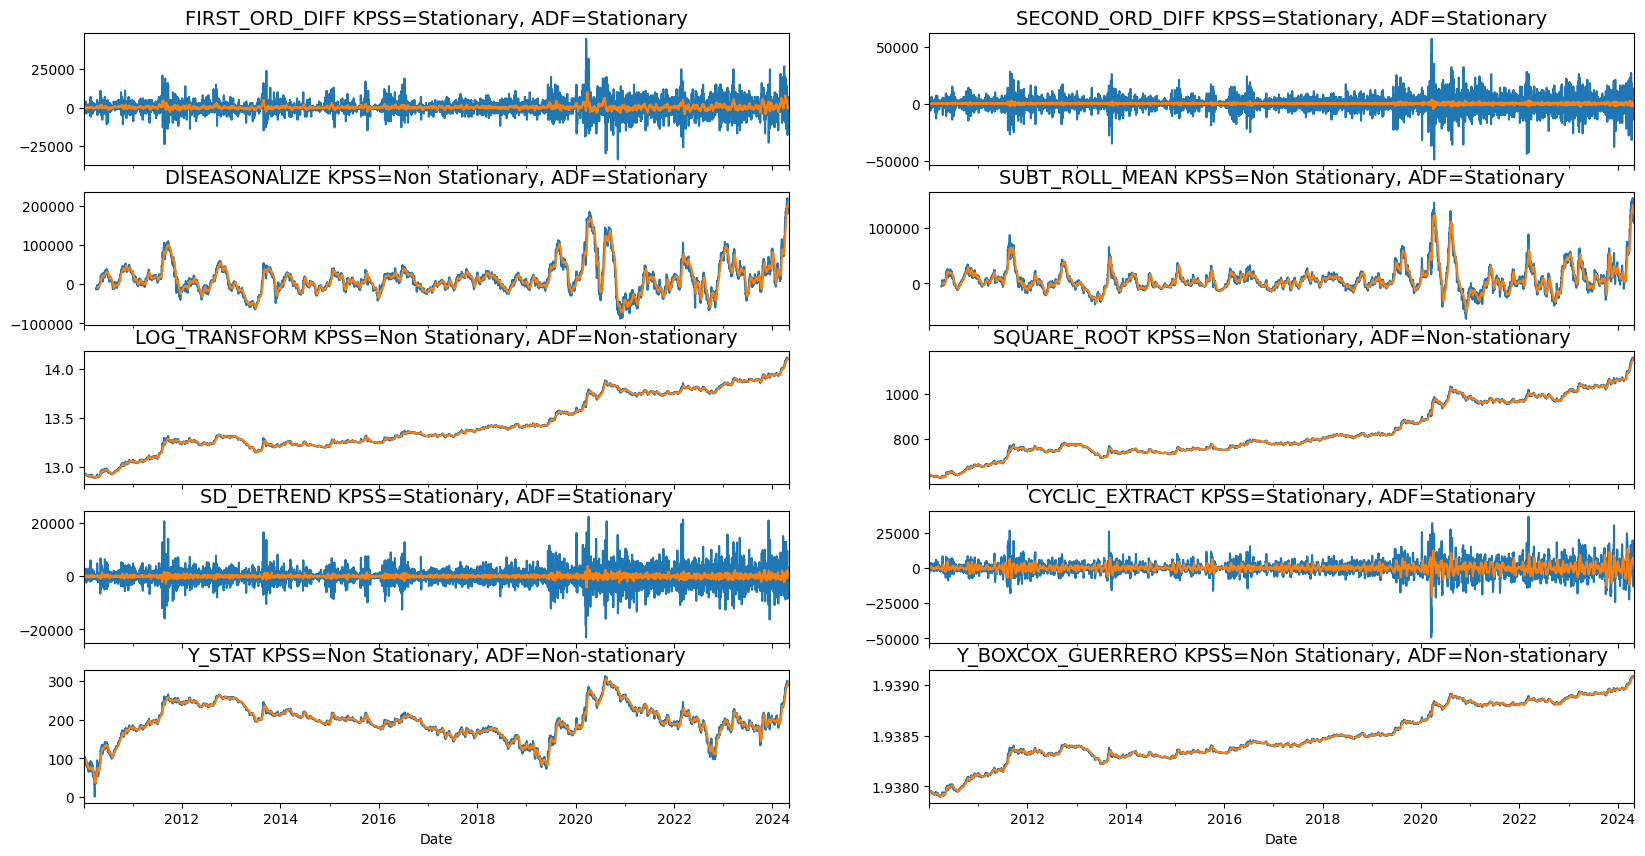

In [28]:
# using first order differencing (detrending)
first_ord_diff = data2_cleaned.diff().dropna()

# using second order differencing
second_ord_diff = data2_cleaned.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = data2_cleaned.diff(90).dropna()

# using rolling mean 
rolling_mean = data2_cleaned.rolling(window=90).mean()
subt_roll_mean = data2_cleaned - rolling_mean

# log transform
log_transform = np.log(data2_cleaned)

# Square root transform
square_root = np.sqrt(data2_cleaned)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(data2_cleaned)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(data2_cleaned)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract,
           y_stat, y_boxcox_guerrero]

plot = plot_comparison(methods)

## Detecting Seasonality

### Plotting ACF & PACF

Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


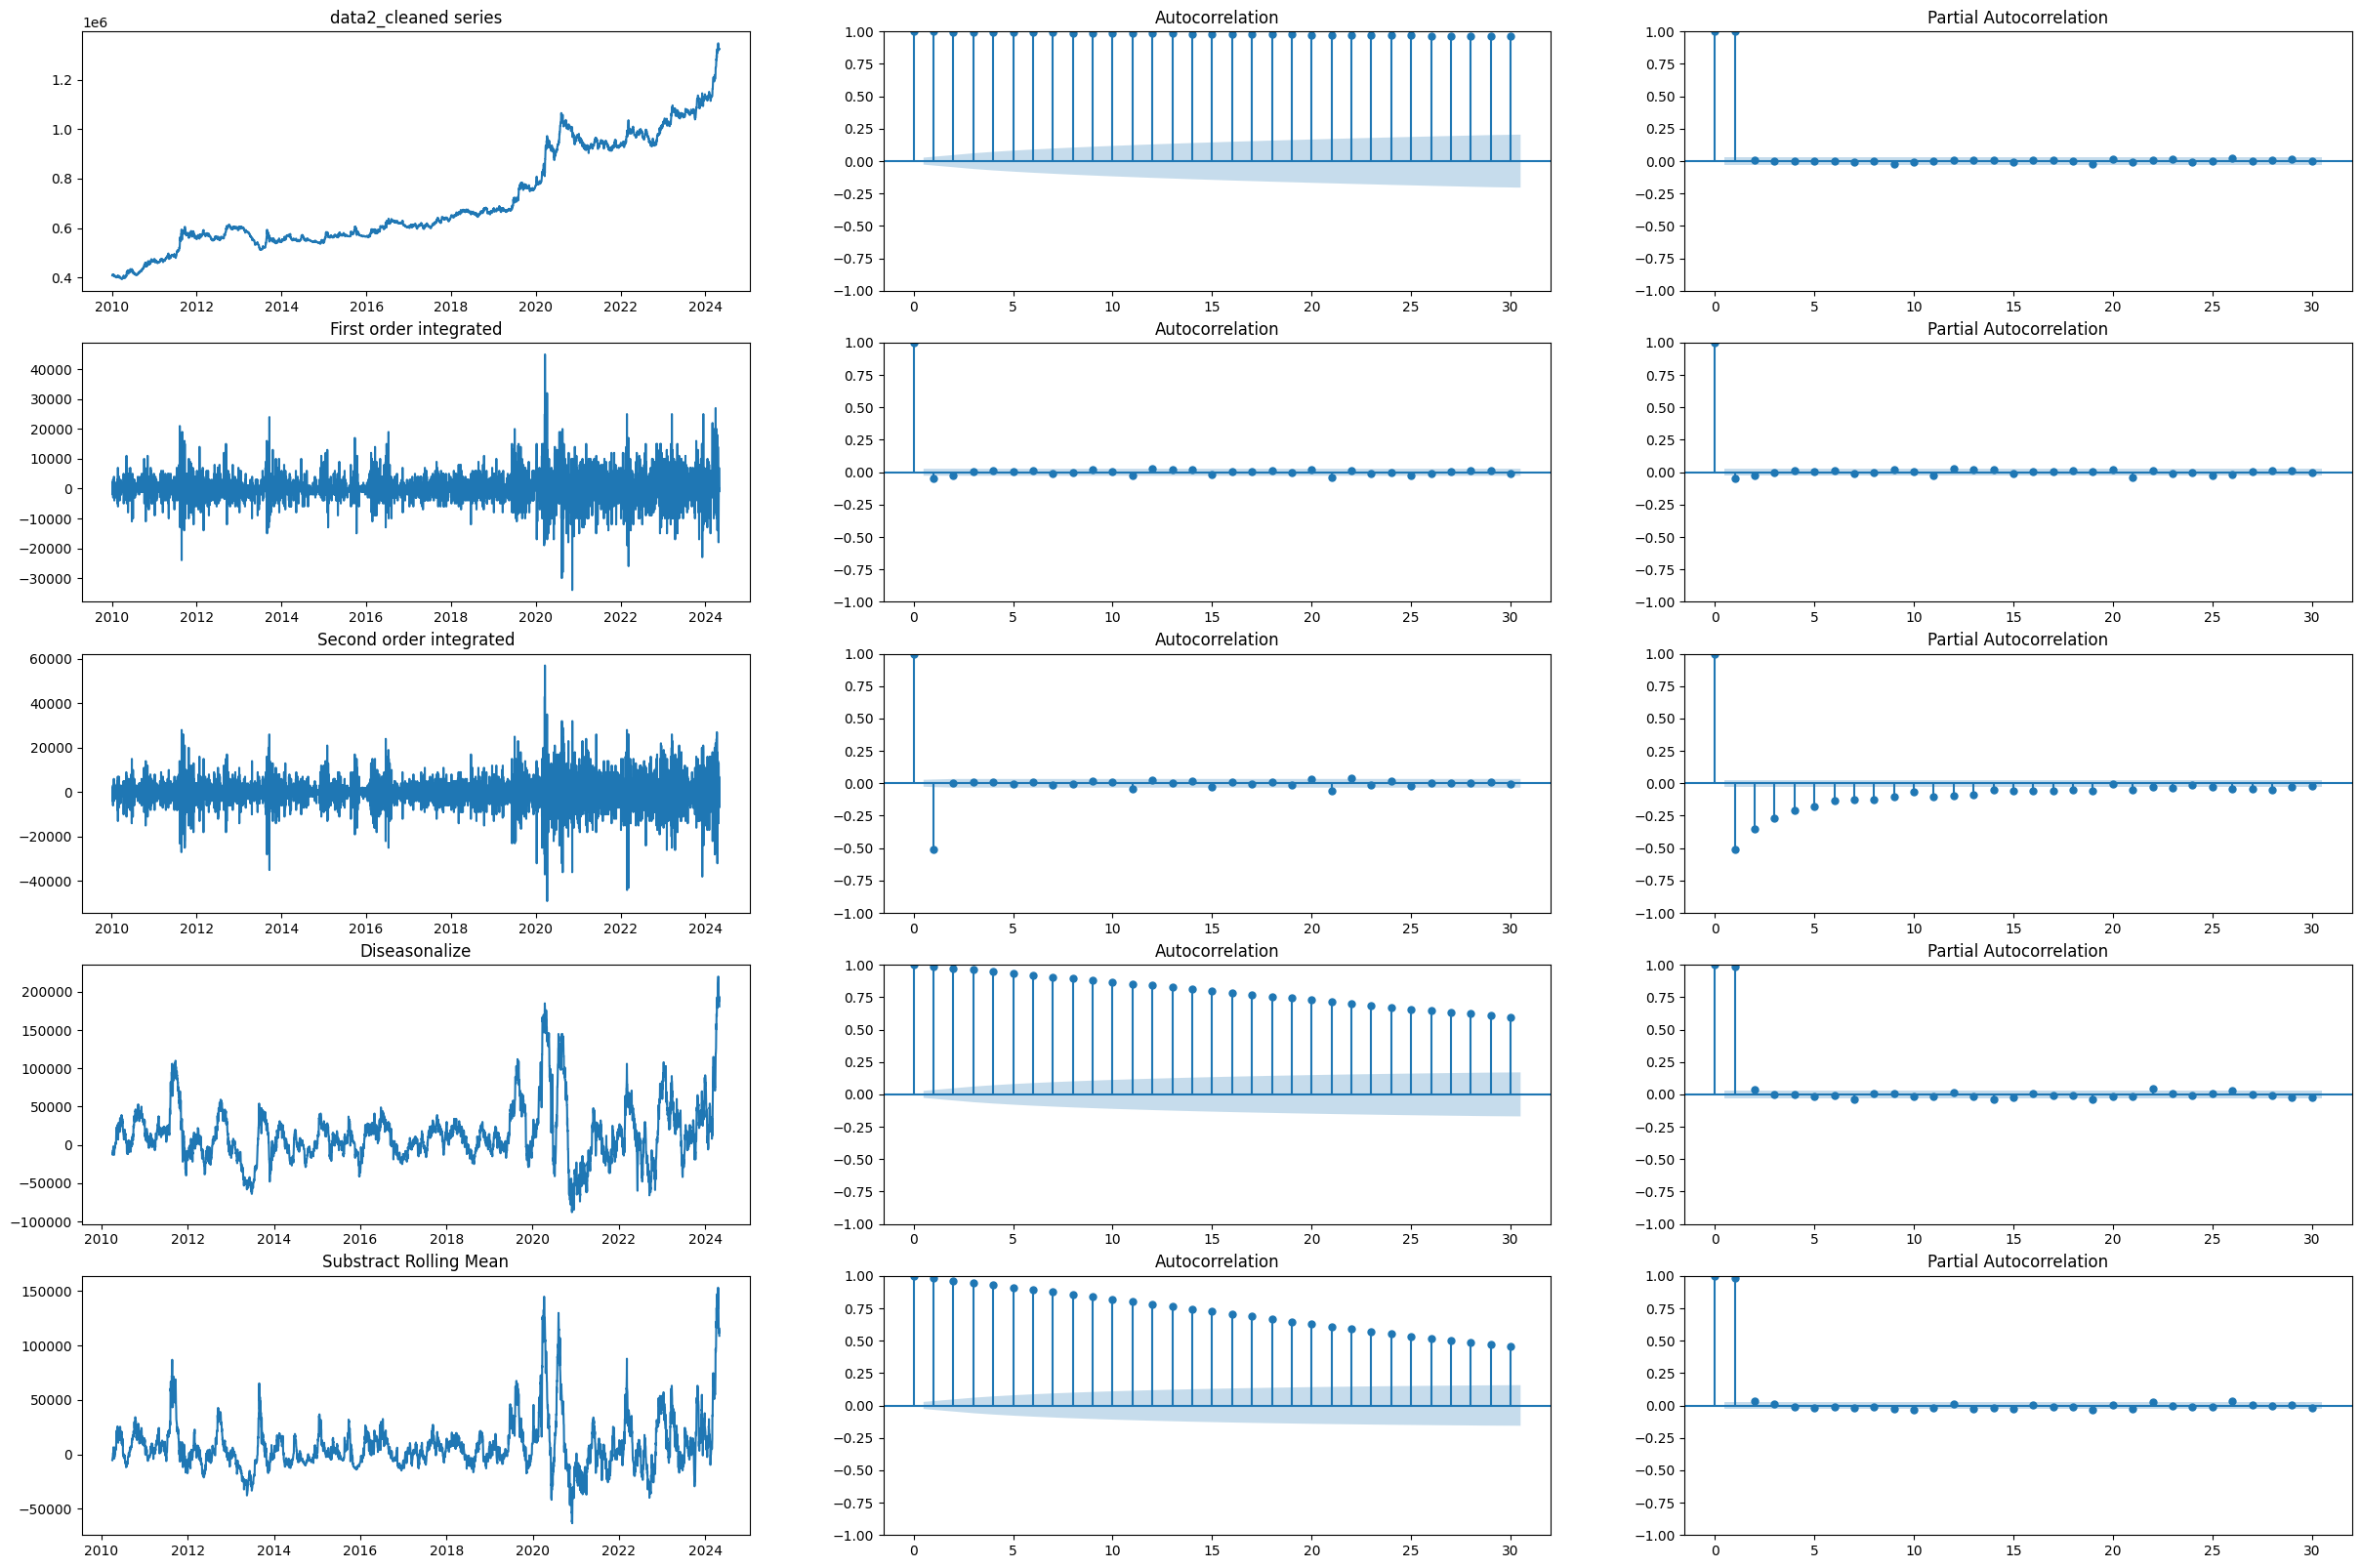

In [29]:
fig, axes = plt.subplots(5, 3, figsize=(30, 20))

# plot original series
axes[0,0].plot(data2_cleaned)
axes[0,0].set_title("data2_cleaned series")
print(plot_acf(data2_cleaned, ax=axes[0,1], lags=30))
print(plot_pacf(data2_cleaned, ax=axes[0,2], lags=30))

# plot first order integrated series
axes[1,0].plot(first_ord_diff)
axes[1,0].set_title("First order integrated")
print(plot_acf(first_ord_diff, ax=axes[1,1], lags=30))
print(plot_pacf(first_ord_diff, ax=axes[1,2], lags=30))

# plot first order integrated series
axes[2,0].plot(second_ord_diff)
axes[2,0].set_title("Second order integrated")
print(plot_acf(second_ord_diff, ax=axes[2,1], lags=30))
print(plot_pacf(second_ord_diff, ax=axes[2,2], lags=30))

# Deseasonalize series
axes[3,0].plot(diseasonalize)
axes[3,0].set_title("Diseasonalize")
print(plot_acf(diseasonalize, ax=axes[3,1], lags=30))
print(plot_pacf(diseasonalize, ax=axes[3,2], lags=30))

# Subtract Rolling Mean series
axes[4,0].plot(subt_roll_mean)
axes[4,0].set_title("Substract Rolling Mean")
print(plot_acf(subt_roll_mean, ax=axes[4,1], lags=30))
print(plot_pacf(subt_roll_mean, ax=axes[4,2], lags=30))

Our initial criterion for stationarity is a _constant mean_. However, our data fails this criterion as depicted by the non-constant mean evident from the plot (shown by the black line). Consequently, our data is deemed non-stationary.

The second criterion concerns constant variance, which appears to be satisfied in our case. Hence, our data meets this condition for stationarity.

Lastly, if the test statistic is lower than the critical value, we can conclude that the time series is stationary. Upon examination, we find that the test statistic is 1.2, whereas the critical values are as follows: {'1%', '5%', '10%'}. Since the test statistic exceeds the critical values, our time series is not stationary.

In summary, based on the above analyses, it is evident that our time series data is not stationary. Consequently, in the subsequent section, we will explore methods to transform the time series into a stationary form.

# Detecting Statistically

In [30]:
def get_var_name(variable):
     for name, value in globals().items():
        if value is variable:
            return name
        
method_names = [get_var_name(method) for method in methods]

### Checking seasonality

In [31]:
for method, method_name in zip(methods, method_names):
    seasonality_res = check_seasonality(method, max_lag=90, seasonal_period=72, confidence=0.05)
    print(f"Seasonality Test for 12th lag using {method_name}: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using first_ord_diff: False
Seasonality Test for 12th lag using second_ord_diff: True
The ACF has no local maximum for m < max_lag = 90. Try larger max_lag
Seasonality Test for 12th lag using diseasonalize: False
Seasonality Test for 12th lag using subt_roll_mean: False
The ACF has no local maximum for m < max_lag = 90. Try larger max_lag
Seasonality Test for 12th lag using log_transform: False
The ACF has no local maximum for m < max_lag = 90. Try larger max_lag
Seasonality Test for 12th lag using square_root: False
Seasonality Test for 12th lag using sd_detrend: False
Seasonality Test for 12th lag using cyclic_extract: False
The ACF has no local maximum for m < max_lag = 90. Try larger max_lag
Seasonality Test for 12th lag using y_stat: False
The ACF has no local maximum for m < max_lag = 90. Try larger max_lag
Seasonality Test for 12th lag using y_boxcox_guerrero: False


### Checking Normality

In [32]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [33]:
normal_args = (np.mean(data2_cleaned),np.std(data2_cleaned))

print(is_normal(shapiro(data2_cleaned)))
print(is_normal(normaltest(data2_cleaned)))
print(is_normal(normal_ad(data2_cleaned)))
print(is_normal(kstest_normal(data2_cleaned)))

Not Normal
Not Normal
Not Normal
Not Normal


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5231.



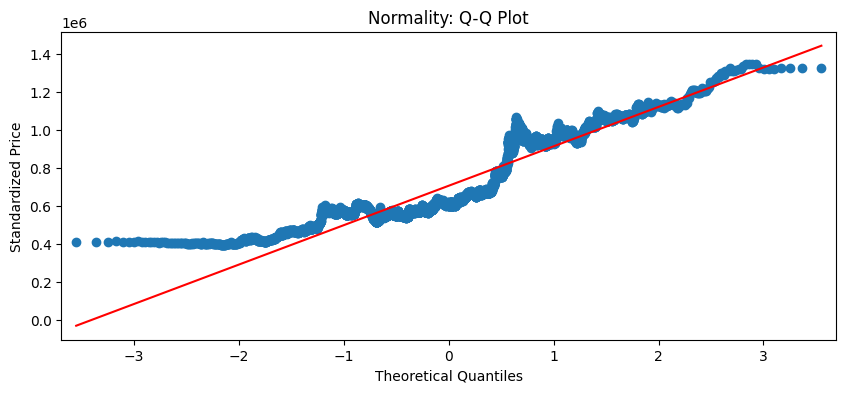

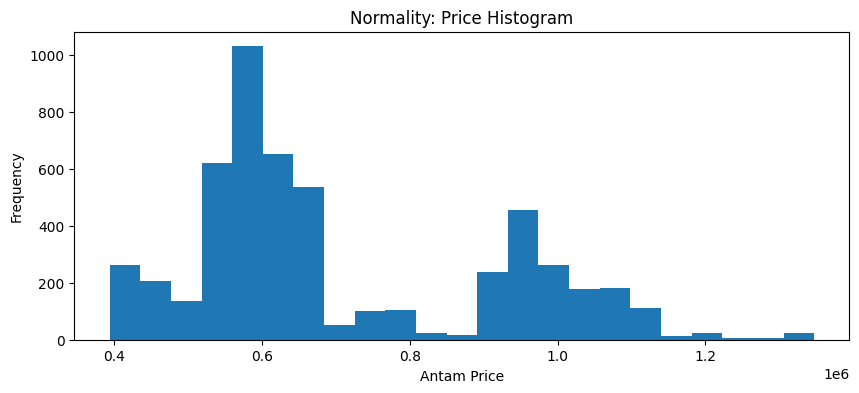

In [34]:
plt.rcParams["figure.figsize"] = [10, 4]

sm.qqplot(data2_cleaned, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Price')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(data2_cleaned, bins='auto')
plt.xlabel('Antam Price')
plt.ylabel('Frequency')
plt.title('Normality: Price Histogram')
plt.show()

### Heteroskedactisity Test

In [35]:
for method, method_name in zip(methods, method_names):
    hetero_white_res = check_heteroscedastisticity(method, confidence=0.05)
    print(f"White Test for Heteroscedasticity on {method_name}: {hetero_white_res.heteroscedastic} with a p-value of {hetero_white_res.lm_p_value}")

White Test for Heteroscedasticity on first_ord_diff: True with a p-value of 9.948438082233556e-34
White Test for Heteroscedasticity on second_ord_diff: True with a p-value of 2.906862268304583e-35
White Test for Heteroscedasticity on diseasonalize: True with a p-value of 4.2789168213682155e-73
White Test for Heteroscedasticity on subt_roll_mean: True with a p-value of 4.9894009817081474e-67
White Test for Heteroscedasticity on log_transform: True with a p-value of 2.5349266345345664e-20
White Test for Heteroscedasticity on square_root: True with a p-value of 6.580856242560322e-24
White Test for Heteroscedasticity on sd_detrend: True with a p-value of 3.204219475353785e-51
White Test for Heteroscedasticity on cyclic_extract: True with a p-value of 1.9049765712521836e-58
White Test for Heteroscedasticity on y_stat: True with a p-value of 2.827725872447749e-92
White Test for Heteroscedasticity on y_boxcox_guerrero: True with a p-value of 1.200689075307459e-123


# Export Cleaned Data

In [36]:
data2_cleaned.to_csv("data/harga-emas-antam-cleaned.csv")